In [12]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from gensim import models, corpora, similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

import pickle

In [13]:
dataset_root = "./data/"

In [14]:
mode = "load" # create | train | load

In [15]:
N_TOPICS = 20
ALPHA="auto"
BETA="auto"

In [16]:
with open(dataset_root + "articles.txt", "r", encoding="utf-8") as f:
    dataset = f.read().split("@delimiter")

In [17]:
print(dataset[0][:70], "...")
print("Number of articles:", len(dataset))



 -- Children in war-ravaged Afghanistan are safer than those growing u ...
Number of articles: 92579


In [18]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [19]:
def filter(tokenized_article):

    return [t.lemma_ for t in tokenized_article if t.is_alpha and not t.is_punct and not t.is_space and not t.is_stop and t.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]

In [20]:
def tokenize(dataset):

    print("Tokenizing the articles...")
    
    tokenized_articles = list(map(filter, nlp.pipe(dataset, n_process=4)))
    
    with open(dataset_root + "tokenized_articles.pkl", "wb") as f_wb:
        pickle.dump(tokenized_articles, f_wb)

    return tokenized_articles

In [21]:
def create_dict(tokenized_articles):

    print("Creating dictionary...")
    
    dictionary = corpora.Dictionary(tokenized_articles)
    # no_below: present in X no. of documents, no_above: present in X % of documents
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    with open(dataset_root + "dictionary.pkl", "wb") as f_wb:
        pickle.dump(dictionary, f_wb)

    return dictionary

In [22]:
def create_corpus(dictionary, tokenized_articles):

    print("Creating corpus...")
    
    corpus = [dictionary.doc2bow(article) for article in tokenized_articles]

    with open(dataset_root + "corpus.pkl", "wb") as f_wb:
        pickle.dump(corpus, f_wb)

    return corpus

In [23]:
def create_model(corpus, dictionary, n_topics=20, passes=15, alpha="auto", beta="auto", random_state=27, save=True):

   mode != "train" and print("Creating LDA model...")
   
   model = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=beta, random_state=random_state)
   
   if save:
      with open(f"./model/model_{N_TOPICS}_{ALPHA}_{BETA}.pkl", "wb") as f_wb:
         pickle.dump(model, f_wb)
      
   return model

In [24]:
def train(mode, topic_range=[1]):

    if (mode == "create"):
        tokenized_articles = tokenize(dataset)
        dictionary = create_dict(tokenized_articles)
        corpus = create_corpus(dictionary, tokenized_articles)
        model = create_model(corpus, dictionary, N_TOPICS, 10, ALPHA, BETA, 27)
        lda_index = lda_index = similarities.MatrixSimilarity(model[corpus], num_features=len(dictionary))
        with open(f"./model/lda_index_{N_TOPICS}_{ALPHA}_{BETA}.pkl", "rb") as f_rb:
            lda_index = pickle.load(f_rb)

    elif (mode == "train"):
        coherence_scores = []
        
        print("Loading tokenized articles...")
        with open(dataset_root + "tokenized_articles.pkl", "rb") as f_rb:
            tokenized_articles = pickle.load(f_rb)

        print("Loading dictionary...")
        with open(dataset_root + "dictionary.pkl", "rb") as f_rb:
            dictionary = pickle.load(f_rb)

        print("Loading corpus...")
        with open(dataset_root + "corpus.pkl", "rb") as f_rb:
            corpus = pickle.load(f_rb)

        for n_topics in topic_range:
            
            print(f"Training LDA with {n_topics} topics...")
            
            model = create_model(corpus, dictionary, n_topics, 5, ALPHA, BETA, random_state=27, save=False)

            print(f"Model created with {n_topics} topics")

            coherence_model_lda = CoherenceModel(model=model, texts=tokenized_articles, dictionary=dictionary, coherence='u_mass')
            coherence_lda = coherence_model_lda.get_coherence()
            coherence_scores.append(coherence_lda)

            print(f"Coherence Score with {n_topics}:", coherence_lda)

        idx = coherence_scores.index(max(coherence_scores))
        optimal_n_topics = topic_range[idx]

        model = create_model(corpus, dictionary, optimal_n_topics, 10, ALPHA, BETA, random_state=27, save=True)

        lda_index = similarities.MatrixSimilarity(model[corpus], num_features=len(dictionary))
        with open(f"./model/lda_index_{N_TOPICS}_{ALPHA}_{BETA}.pkl", "wb") as f_wb:
            pickle.dump(lda_index, f_wb)
        
    elif (mode == "load"):
        with open(dataset_root + "tokenized_articles.pkl", "rb") as f_rb:
            tokenized_articles = pickle.load(f_rb)

        with open(dataset_root + "dictionary.pkl", "rb") as f_rb:
            dictionary = pickle.load(f_rb)

        with open(dataset_root + "corpus.pkl", "rb") as f_rb:
            corpus = pickle.load(f_rb)

        with open(f"./model/model_{N_TOPICS}_{ALPHA}_{BETA}.pkl", "rb") as f_rb:
            model = pickle.load(f_rb)

        with open(f"./model/lda_index_{N_TOPICS}_{ALPHA}_{BETA}.pkl", "rb") as f_rb:
            lda_index = pickle.load(f_rb)
    
    return tokenized_articles, dictionary, corpus, model, lda_index

In [25]:
tokenized_articles, dictionary, corpus, model, lda_index  = train(mode)

In [26]:
article_idx = 0
print(dataset[article_idx][:300]) 

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa


In [27]:
dictionary[0]

'absence'

In [28]:
topics = sorted(model.get_document_topics(corpus[article_idx]), key=lambda tup: tup[1])[::-1]
topics

[(8, 0.29703873),
 (3, 0.1558213),
 (15, 0.13068438),
 (19, 0.089003585),
 (1, 0.08508419),
 (4, 0.073049866),
 (14, 0.070672125),
 (6, 0.053960893),
 (5, 0.038658608)]

In [29]:
model.show_topic(topics[1][0])

[('school', 0.054379415),
 ('child', 0.04502617),
 ('student', 0.03829228),
 ('parent', 0.019186072),
 ('kid', 0.014519241),
 ('program', 0.014237393),
 ('girl', 0.012957997),
 ('college', 0.011505205),
 ('young', 0.011324767),
 ('help', 0.011149432)]

In [30]:
def get_top_topics(article_idx, min_topic_prob):

  # Sort from highest to lowest topic probability.
  topic_prob_pairs = sorted(model.get_document_topics(corpus[article_idx],
                                                          minimum_probability=min_topic_prob),
                            key=lambda tup: tup[1])[::-1]

  word_prob_pairs = [model.show_topic(pair[0]) for pair in topic_prob_pairs]
  topic_words = [[pair[0] for pair in collection] for collection in word_prob_pairs]

  data = {
      'Major Topics': topic_prob_pairs,
      'Topic Words': topic_words
  }

  return pd.DataFrame(data)

In [31]:
pd.set_option('max_colwidth', 600)
snippet_length = 300
min_topic_prob = 0.25

article_idx = 1
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach into hotels and casinos -- but its chief executive says the brand will remain "special."

"We don't want to be in every street corner, in every city of the UK," Hard Rock's Hamish Dodds told CNN.

"We wa


,Major Topics,Topic Words
0,"(18, 0.38314903)","[company, oil, country, world, new, market, industry, energy, business, project]"
1,"(17, 0.3377055)","[city, hotel, food, place, restaurant, room, travel, art, local, good]"


In [32]:
article_idx = 10
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop


,Major Topics,Topic Words
0,"(11, 0.6730296)","[pay, money, job, government, work, cost, tax, cut, care, health]"


In [33]:
coherence_model_lda = CoherenceModel(model=model, texts=tokenized_articles, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  -1.5419585170548302


In [34]:
def render_word_cloud(model, rows, cols, max_words):

  if (mode == "load"):
    plt.imshow(plt.imread("output.png"))
  else:
    word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(15,15))

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(model.show_topic(i))
        word_cloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(word_cloud, interpolation='bilinear')
        plt.gca().set_title('Topic {id}'.format(id=i))
        plt.gca().axis('off')

    plt.axis('off')
    plt.show()

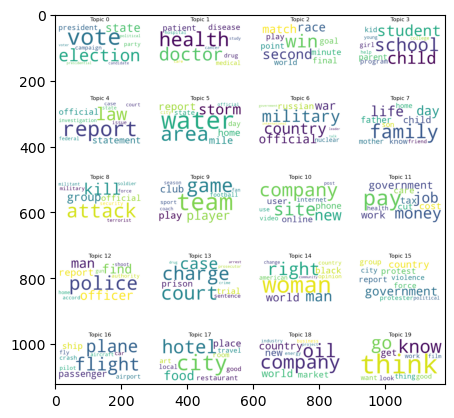

In [35]:
render_word_cloud(model, 5, 4, 10)

In [36]:
def get_similar_articles(index, model, article_bow, top_n=5, first_m_words=300):
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]
  
  return list(map(lambda entry: (entry[0], entry[1], dataset[entry[0]][:first_m_words]), top_n_docs))

In [ ]:
test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

article_tokens = list(map(filter, [nlp(test_article)]))[0]
article_bow = dictionary.doc2bow(article_tokens)
similar_articles = get_similar_articles(lda_index, model, article_bow)

In [38]:
pd.DataFrame(similar_articles, columns=["ID", "Similarity", "Article Text"])

,ID,Similarity,Article Text
0,79420,0.995843,"\n -- Seven former Merrill Lynch executives have been subpoenaed by New York Attorney General Andrew Cuomo over $3.6 billion in bonuses paid out just before the company was acquired by federally bailed-out Bank of America last year, a source close to the investigation told CNN.\n\nSeven former Merrill"
1,60150,0.994040,"\n -- The Federal Emergency Management Agency has not attempted to recoup some $643 million in payments that were improperly given to 160,000 individuals for housing and other aid following Hurricanes Katrina and Rita, an independent government investigator says.\n\nIn a letter to FEMA Administrator Cr"
2,9256,0.992631,"\n -- Two whistleblowers will divide nearly a half million dollars following the latest settlement between the Justice Department and independent contracting firms working in Iraq.\n\nDynCorp agreed to pay the U.S. government $7.7 million, and its subcontractor The Sandi Group promised to pay a bit"
3,44376,0.991048,"\n -- Barclays on Monday announced the resignation of its chairman, Marcus Agius, in the widening scandal surrounding the bank's manipulation of interbank lending rates in 2008 and 2009.\n\nIn a statement to the London Stock Exchange, Agius said the scandal has ""dealt a devastating blow"" to Barclays' r"
4,14085,0.986803,"\nNearly a dozen fake applicants were able to obtain coverage subsidies under Obamacare during undercover testing of enrollment controls, a government watchdog said.\n\nThe Government Accountability Office, the investigative arm of Congress, created 18 fictitious applicants to test the Affordable Care"
